In [1]:
import pandas as pd
import numpy as np
from stockstats import StockDataFrame as Sdf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from preprocess.dataloader import load_data, clean_data
from preprocess.data_generator import generate_trading_data
from preprocess.indicator_factory import add_indicators_all, add_indicators
from evals import eval_trend_return_acc
from utils.date_util import get_current_report_quarter

import torch
from datetime import datetime

In [2]:
# Backtest scenario:

# Input: testing period: (start_test_date - end_test_date)
#        all_data: loading stock data, must including test period and some time before to calculate MA20
#        stock_list: list of all stocks
#        stock_infos: basic df of information of the stocks, including their exchanges and industry
#        filters: there are three filters used in this backtest: CANSLIM, intrinsic_values and FA_scoring

#Output: simulation of n backtesting scenario, each scenario follows the strategy: 5 stock max, each stock 
# is allocated with equal position (20% NAV), sell when reach trailing stoploss (7%); each scenario is able 
# to visualize the line and important metrics (win_rate, sharpe_ratio, e.t.c)


In [3]:
import os, random, time

seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
# Torch RNG
# torch.manual_seed(seed)
# torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
# Python RNG
np.random.seed(seed)
random.seed(seed)

torch.backends.cudnn.benchmark=False
torch.backends.cudnn.deterministic=True
torch.backends.cudnn.enabled=False

os.environ['CUBLAS_WORKSPACE_CONFIG'] = ":16:8"
os.environ['TZ'] = 'Asia/Saigon'
time.tzset()

In [4]:
data_src = "data/Vietnam"
stock_list = np.load(data_src + "/list_stocks.npy", allow_pickle = True)
stock_infos = pd.read_csv("data/Vietnam/stock_infos.csv", index_col = "ticker")
price_estimator = pd.read_csv(data_src + "/estimate_price.csv")



In [5]:
from preprocess.dataloader import load_data, clean_data
from preprocess.data_generator import generate_trading_data
from datetime import datetime
from utils.date_util import get_most_recent_trade_day
from pytz import timezone

stock_data = {}

# start_data_date = datetime.strptime("2020-02-10 09:00:00", '%Y-%m-%d %H:%M:%S')
start_data_date = datetime.strptime("2021-02-01", '%Y-%m-%d')
# start_data_date = datetime.strptime("2018-10-01 09:00:00", '%Y-%m-%d %H:%M:%S')
now = datetime.now(timezone('Europe/Berlin')).replace(tzinfo=None) 
end_data_date = datetime.strptime("2023-01-30", '%Y-%m-%d')
# end_data_date = get_most_recent_trade_day(now)[0]
ohclv_data_src = "data/Vietnam/OHCLV"
interval = "1day"
periods = [5, 20]
indicators = ["MACD", "rsi", "mfi", "close_sma", "volume_sma", "rs", "boll", "psar", "supertrend"]

stocks = []

for stock in stock_list:            
    source_df = load_data(stock, ohclv_data_src, interval, start_data_date, end_data_date)      
    if start_data_date != source_df.index[0]:
        print("Remove {} because of missing data".format(stock))
    else:
        stocks.append(stock)
        stock_data[stock] = source_df
        
    if len(stocks) == 0:
        print("Error: the start data date is invalid, please check if it is a weekend or holiday")

    stock_data = clean_data(stock_data, stocks)

# daily_data_storage, daily_features_storage = add_indicators_all(stock_data, indicators, periods = periods, trend_ahead = 5)


SHB is missing at: ['2021-10-06T00:00:00.000000000' '2021-10-07T00:00:00.000000000'
 '2021-10-08T00:00:00.000000000']
VND is missing at: ['2021-03-31T00:00:00.000000000' '2021-04-01T00:00:00.000000000'
 '2021-04-02T00:00:00.000000000' '2021-08-30T00:00:00.000000000'
 '2021-08-31T00:00:00.000000000' '2021-09-01T00:00:00.000000000']
PAN is missing at: ['2021-04-13T00:00:00.000000000' '2021-04-14T00:00:00.000000000'
 '2021-04-15T00:00:00.000000000' '2021-08-30T00:00:00.000000000'
 '2021-08-31T00:00:00.000000000' '2021-09-01T00:00:00.000000000'
 '2021-09-06T00:00:00.000000000']
TVB is missing at: ['2021-04-13T00:00:00.000000000' '2021-04-14T00:00:00.000000000'
 '2021-04-15T00:00:00.000000000' '2021-08-30T00:00:00.000000000'
 '2021-08-31T00:00:00.000000000' '2021-09-01T00:00:00.000000000']


In [6]:
# #Load VNI data

# vni_df = load_data("VNINDEX", ohclv_data_src, interval, start_data_date, end_data_date)    
# vni_df, features = add_indicators(vni_df, indicators, periods, trend_ahead = 5)



In [7]:
# start_test_date = datetime.strptime("2019-02-15 09:00:00", '%Y-%m-%d %H:%M:%S')
# start_test_date = datetime.strptime("2022-02-15 09:00:00", '%Y-%m-%d %H:%M:%S')
# start_test_date = datetime.strptime("2020-06-15 09:00:00", '%Y-%m-%d %H:%M:%S')
start_test_date = datetime.strptime("2021-07-01", '%Y-%m-%d')
end_test_date = end_data_date


X_test_storage = []
y_test_storage = []
df_test_storage = []
target_col = "trend_return"
setting = "many_to_many"
daily_history_window = 20
light_indicators = ["MACD", "rsi", "mfi", "close_sma", "volume_sma", "rs", "boll", "psar", "supertrend"]
light_daily_data_storage, light_daily_features_storage = add_indicators_all(stock_data, light_indicators, periods = periods, trend_ahead = 5)

for ticker in stocks:
    
    X_test, y_test, df_test = generate_trading_data(light_daily_data_storage[ticker], light_daily_features_storage[ticker], target_col, daily_history_window, start_test_date, end_test_date, setting = setting)
    X_test_storage.append(X_test)
    y_test_storage.append(y_test)
    df_test_storage.append(df_test)

In [8]:
from preprocess.dataloader import prepare_env_df
from backtest.backtest_light import Backtest
from tqdm import tqdm

In [9]:
test_env_df = prepare_env_df(df_test_storage)
trade_sessions = test_env_df["date"].unique()

num_test_day = len(trade_sessions)
num_stock = len(stock_list)

#Initialize the test_preds of the shape (num_test_date, len_stocks). 
#test_preds[i, j] indicates the probability of stock j is bought at day i
#As no learning model is used, the test_preds is initialized with 1 and threshold is 0.5 (always possible to buy)

test_preds = np.ones((num_test_day, len(stocks)))
thresholds =  np.array([0.5] * len(stocks))

In [10]:
test_env_df

,date,symbol,open,high,low,close,volume,ticker,close_sma_5,close_sma_5_ratio,...,close_r,volume_r,daily_return,stability,trend_return,trend_log_return,trend,agg_changes,rs,rs_change
0,2021-07-01,HOSE:VCB,"116,700.000","116,800.000","115,000.000","116,400.000","2,056,400.000",VCB,"114,400.000",0.017,...,0.000,-0.384,0.000,0.015,-0.046,-0.048,2,0.210,0.520,0.520
1,2021-07-02,HOSE:VCB,"116,400.000","116,600.000","114,000.000","114,900.000","1,767,290.000",VCB,"114,860.000",0.000,...,-0.013,-0.141,-0.013,0.016,-0.044,-0.045,2,0.144,0.450,-0.070
2,2021-07-05,HOSE:VCB,"113,900.000","113,900.000","110,900.000","113,600.000","2,416,000.000",VCB,"115,060.000",-0.013,...,-0.011,0.367,-0.011,0.013,-0.057,-0.059,2,0.122,0.440,-0.010
3,2021-07-06,HOSE:VCB,"112,500.000","115,000.000","112,000.000","112,000.000","1,754,600.000",VCB,"114,660.000",-0.023,...,-0.014,-0.274,-0.014,0.012,-0.077,-0.080,2,0.108,0.520,0.080
4,2021-07-07,HOSE:VCB,"112,000.000","113,400.000","106,000.000","113,400.000","2,808,000.000",VCB,"114,060.000",-0.006,...,0.012,0.600,0.012,0.014,-0.102,-0.108,2,0.125,0.530,0.010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81159,2023-01-17,HOSE:VPH,"4,000.000","4,090.000","3,980.000","4,050.000","156,700.000",VPH,"4,072.000",-0.005,...,-0.005,1.325,-0.005,0.020,NaN,NaN,0,-0.327,0.060,-0.040
81160,2023-01-18,HOSE:VPH,"4,050.000","4,150.000","4,000.000","4,060.000","56,200.000",VPH,"4,064.000",-0.001,...,0.002,-0.641,0.002,0.009,NaN,NaN,0,-0.316,0.050,-0.010
81161,2023-01-19,HOSE:VPH,"4,180.000","4,200.000","4,060.000","4,100.000","64,000.000",VPH,"4,076.000",0.006,...,0.010,0.139,0.010,0.009,NaN,NaN,0,-0.281,0.060,0.010
81162,2023-01-27,HOSE:VPH,"4,140.000","4,230.000","4,140.000","4,150.000","88,800.000",VPH,"4,086.000",0.016,...,0.012,0.387,0.012,0.010,NaN,NaN,0,-0.261,0.050,-0.010


In [11]:
# 3 filters are applied here. For each trading day, only the stocks that satisfy all 3 filters are allowed to buy

filters = ["CANSLIM", "TA_scoring", "intrinsic_value"]
# filters = []
backtest = Backtest(test_env_df, stock_infos, test_preds[:, :], filters, max_number_of_stock = 5, buy_thresholds = thresholds, sell_thresholds = -thresholds, ta_score_threshold = 4, t_delay = 2, intrinsic_mos = 0.2)


Loading intrinsic values for backtesting
VCB
VIC
VHM
GAS
HPG
VPB
NVL
VNM
TCB
BID
MSN
CTG
GVR
MBB
VGI
MWG
SAB
FPT
BCM
ACB
VRE
VJC
BSR
VIB
PLX
TPB
STB
HDB
HVN
BVH
SHB
THD
DGC
EIB
MSB
SSI
OCB
DIG
KDH
POW
PDR
DPM
REE
KBC
PNJ
GEX
DXG
VGC
DCM
LPB
VHC
NLG
IDC
GMD
VCS
QNS
NVB
KDC
OIL
VCI
HSG
VND
VPI
VCG
FRT
DGW
ITA
HCM
SBT
PVS
HDG
TCH
CEO
VGT
BWE
PHR
HAG
PC1
SJS
BCG
PVD
TVN
HPX
NAB
NKG
HNG
MBS
HUT
QTP
KOS
ABB
FTS
HT1
SGP
CII
PVT
GEG
CMG
NT2
HDC
CRE
SHS
SCR
PPC
IDI
SZC
ANV
DHC
L14
PTB
VSC
PAN
HBC
TCM
ASM
BMP
DVN
OGC
SAM
IJC
AAA
MSH
VPG
PET
CTD
FMC
VIX
BMI
TDM
MIG
TTF
HTN
HAH
DPG
DRC
TVS
APH
GIL
DPR
DDV
LDG
DBC
DBD
AGG
QCG
AGR
LTG
FCN
TNG
TCD
POM
KSB
HQC
FIT
VDS
PLC
LCG
CTS
HHS
TV2
TIG
VOS
CSV
SHI
PSH
LHG
SGT
SMC
BCC
TNH
EVS
BVS
TTA
BFC
CKG
NTL
CSC
C4G
CMX
TSC
CTF
LAS
DCL
TDC
APG
IBC
DLG
APS
NRC
D2D
ACL
TLH
G36
IDJ
TVB
TVC
SBS
HAX
ABS
VNE
ITC
NHA
EVG
VGS
DRH
VPH


In [12]:
backtest.execute(num_test = 1000)

  0%|                                            | 1/1000 [00:00<02:59,  5.57it/s]

Test 0


  1%|▍                                          | 11/1000 [00:01<02:14,  7.36it/s]

Test 10


  2%|▉                                          | 21/1000 [00:03<02:58,  5.50it/s]

Test 20


  3%|█▎                                         | 31/1000 [00:05<02:24,  6.72it/s]

Test 30


  4%|█▊                                         | 41/1000 [00:06<02:42,  5.91it/s]

Test 40


  5%|██▏                                        | 51/1000 [00:08<02:33,  6.18it/s]

Test 50


  6%|██▌                                        | 61/1000 [00:09<02:21,  6.63it/s]

Test 60


  7%|███                                        | 71/1000 [00:11<02:27,  6.31it/s]

Test 70


  8%|███▍                                       | 81/1000 [00:12<02:00,  7.65it/s]

Test 80


  9%|███▉                                       | 91/1000 [00:14<02:19,  6.53it/s]

Test 90


 10%|████▏                                     | 101/1000 [00:15<02:05,  7.14it/s]

Test 100


 11%|████▋                                     | 111/1000 [00:16<01:57,  7.59it/s]

Test 110


 12%|█████                                     | 121/1000 [00:18<02:03,  7.10it/s]

Test 120


 13%|█████▌                                    | 131/1000 [00:19<01:51,  7.77it/s]

Test 130


 14%|█████▉                                    | 141/1000 [00:20<01:47,  7.97it/s]

Test 140


 15%|██████▎                                   | 151/1000 [00:22<01:58,  7.15it/s]

Test 150


 16%|██████▊                                   | 161/1000 [00:23<02:02,  6.83it/s]

Test 160


 17%|███████▏                                  | 171/1000 [00:24<01:56,  7.10it/s]

Test 170


 18%|███████▌                                  | 181/1000 [00:26<01:53,  7.18it/s]

Test 180


 19%|████████                                  | 191/1000 [00:27<01:41,  7.97it/s]

Test 190


 20%|████████▍                                 | 201/1000 [00:29<01:57,  6.79it/s]

Test 200


 21%|████████▊                                 | 211/1000 [00:30<01:47,  7.32it/s]

Test 210


 22%|█████████▎                                | 221/1000 [00:31<01:26,  9.03it/s]

Test 220


 23%|█████████▋                                | 231/1000 [00:33<01:54,  6.74it/s]

Test 230


 24%|██████████                                | 241/1000 [00:34<01:35,  7.94it/s]

Test 240


 25%|██████████▌                               | 251/1000 [00:35<01:36,  7.79it/s]

Test 250


 26%|██████████▉                               | 261/1000 [00:37<01:31,  8.06it/s]

Test 260


 27%|███████████▍                              | 271/1000 [00:38<01:33,  7.80it/s]

Test 270


 28%|███████████▊                              | 281/1000 [00:39<01:29,  8.07it/s]

Test 280


 29%|████████████▏                             | 291/1000 [00:40<01:28,  7.98it/s]

Test 290


 30%|████████████▋                             | 301/1000 [00:42<01:40,  6.98it/s]

Test 300


 31%|█████████████                             | 311/1000 [00:43<01:47,  6.38it/s]

Test 310


 32%|█████████████▍                            | 320/1000 [00:45<01:56,  5.82it/s]

Test 320


 33%|█████████████▊                            | 330/1000 [00:47<02:08,  5.23it/s]

Test 330


 34%|██████████████▎                           | 341/1000 [00:48<01:32,  7.11it/s]

Test 340


 35%|██████████████▋                           | 351/1000 [00:50<01:37,  6.67it/s]

Test 350


 36%|███████████████                           | 360/1000 [00:51<01:53,  5.65it/s]

Test 360


 37%|███████████████▌                          | 371/1000 [00:53<01:35,  6.59it/s]

Test 370


 38%|████████████████                          | 381/1000 [00:55<01:31,  6.77it/s]

Test 380


 39%|████████████████▍                         | 391/1000 [00:56<01:10,  8.60it/s]

Test 390


 40%|████████████████▊                         | 401/1000 [00:57<01:11,  8.43it/s]

Test 400


 41%|█████████████████▎                        | 411/1000 [00:59<01:31,  6.41it/s]

Test 410


 42%|█████████████████▋                        | 421/1000 [01:00<01:28,  6.56it/s]

Test 420


 43%|██████████████████                        | 431/1000 [01:02<01:38,  5.79it/s]

Test 430


 44%|██████████████████▌                       | 441/1000 [01:04<01:26,  6.46it/s]

Test 440


 45%|██████████████████▉                       | 451/1000 [01:05<01:15,  7.25it/s]

Test 450


 46%|███████████████████▎                      | 460/1000 [01:07<01:17,  6.97it/s]

Test 460


 47%|███████████████████▊                      | 471/1000 [01:08<01:12,  7.34it/s]

Test 470


 48%|████████████████████▏                     | 480/1000 [01:10<01:27,  5.93it/s]

Test 480


 49%|████████████████████▌                     | 491/1000 [01:12<01:26,  5.85it/s]

Test 490


 50%|█████████████████████                     | 501/1000 [01:13<01:29,  5.59it/s]

Test 500


 51%|█████████████████████▍                    | 511/1000 [01:15<01:20,  6.10it/s]

Test 510


 52%|█████████████████████▉                    | 521/1000 [01:17<01:26,  5.53it/s]

Test 520


 53%|██████████████████████▎                   | 531/1000 [01:19<01:22,  5.67it/s]

Test 530


 54%|██████████████████████▋                   | 541/1000 [01:20<01:13,  6.22it/s]

Test 540


 55%|███████████████████████▏                  | 551/1000 [01:22<00:55,  8.08it/s]

Test 550


 56%|███████████████████████▌                  | 561/1000 [01:23<00:56,  7.79it/s]

Test 560


 57%|███████████████████████▉                  | 571/1000 [01:25<01:08,  6.28it/s]

Test 570


 58%|████████████████████████▍                 | 581/1000 [01:26<00:58,  7.22it/s]

Test 580


 59%|████████████████████████▊                 | 591/1000 [01:28<01:01,  6.60it/s]

Test 590


 60%|█████████████████████████▏                | 601/1000 [01:29<00:56,  7.05it/s]

Test 600


 61%|█████████████████████████▋                | 611/1000 [01:30<00:49,  7.92it/s]

Test 610


 62%|██████████████████████████                | 621/1000 [01:32<00:48,  7.83it/s]

Test 620


 63%|██████████████████████████▌               | 631/1000 [01:33<00:47,  7.71it/s]

Test 630


 64%|██████████████████████████▉               | 641/1000 [01:34<00:45,  7.84it/s]

Test 640


 65%|███████████████████████████▎              | 651/1000 [01:36<00:47,  7.30it/s]

Test 650


 66%|███████████████████████████▊              | 661/1000 [01:37<00:47,  7.10it/s]

Test 660


 67%|████████████████████████████▏             | 671/1000 [01:38<00:44,  7.42it/s]

Test 670


 68%|████████████████████████████▌             | 681/1000 [01:39<00:36,  8.75it/s]

Test 680


 69%|█████████████████████████████             | 691/1000 [01:41<00:34,  8.86it/s]

Test 690


 70%|█████████████████████████████▍            | 701/1000 [01:42<00:37,  7.93it/s]

Test 700


 71%|█████████████████████████████▊            | 710/1000 [01:43<00:45,  6.43it/s]

Test 710


 72%|██████████████████████████████▎           | 721/1000 [01:45<00:37,  7.44it/s]

Test 720


 73%|██████████████████████████████▋           | 731/1000 [01:46<00:33,  7.94it/s]

Test 730


 74%|███████████████████████████████           | 741/1000 [01:47<00:34,  7.50it/s]

Test 740


 75%|███████████████████████████████▌          | 751/1000 [01:49<00:31,  7.93it/s]

Test 750


 76%|███████████████████████████████▉          | 761/1000 [01:50<00:32,  7.47it/s]

Test 760


 77%|████████████████████████████████▍         | 771/1000 [01:51<00:25,  8.94it/s]

Test 770


 78%|████████████████████████████████▊         | 781/1000 [01:52<00:23,  9.41it/s]

Test 780


 79%|█████████████████████████████████▏        | 791/1000 [01:54<00:28,  7.42it/s]

Test 790


 80%|█████████████████████████████████▋        | 801/1000 [01:56<00:28,  7.07it/s]

Test 800


 81%|██████████████████████████████████        | 811/1000 [01:57<00:26,  7.05it/s]

Test 810


 82%|██████████████████████████████████▍       | 821/1000 [01:58<00:25,  7.13it/s]

Test 820


 83%|██████████████████████████████████▉       | 831/1000 [02:00<00:22,  7.41it/s]

Test 830


 84%|███████████████████████████████████▎      | 841/1000 [02:01<00:25,  6.34it/s]

Test 840


 85%|███████████████████████████████████▋      | 851/1000 [02:03<00:20,  7.11it/s]

Test 850


 86%|████████████████████████████████████▏     | 861/1000 [02:04<00:22,  6.26it/s]

Test 860


 87%|████████████████████████████████████▌     | 871/1000 [02:06<00:18,  6.91it/s]

Test 870


 88%|█████████████████████████████████████     | 881/1000 [02:07<00:16,  7.40it/s]

Test 880


 89%|█████████████████████████████████████▍    | 891/1000 [02:08<00:14,  7.72it/s]

Test 890


 90%|█████████████████████████████████████▊    | 901/1000 [02:10<00:13,  7.11it/s]

Test 900


 91%|██████████████████████████████████████▎   | 911/1000 [02:11<00:11,  7.79it/s]

Test 910


 92%|██████████████████████████████████████▋   | 921/1000 [02:12<00:09,  8.07it/s]

Test 920


 93%|███████████████████████████████████████   | 931/1000 [02:14<00:09,  7.27it/s]

Test 930


 94%|███████████████████████████████████████▌  | 941/1000 [02:15<00:07,  8.25it/s]

Test 940


 95%|███████████████████████████████████████▉  | 951/1000 [02:16<00:05,  8.28it/s]

Test 950


 96%|████████████████████████████████████████▎ | 961/1000 [02:17<00:05,  6.68it/s]

Test 960


 97%|████████████████████████████████████████▊ | 971/1000 [02:19<00:04,  6.47it/s]

Test 970


 98%|█████████████████████████████████████████▏| 981/1000 [02:20<00:02,  7.37it/s]

Test 980


 99%|█████████████████████████████████████████▌| 991/1000 [02:22<00:01,  6.51it/s]

Test 990


100%|█████████████████████████████████████████| 1000/1000 [02:23<00:00,  6.96it/s]


In [13]:
backtest.statistic()

Best trade
Sharp ratio: 1.1843487825000005
Gain ratio: 1.766141460838934
Total trade: 97
Win rate: 0.3402061855670103
Max profit: 0.44176258976021954
Max lost: -0.12589028914540645
Worst trade
Sharp ratio: 0.7539767400000001
Gain ratio: 1.1243559335716014
Total trade: 99
Win rate: 0.30303030303030304
Max profit: 0.44176258976021954
Max lost: -0.3022965551672492
Mean
0.9717801912875005


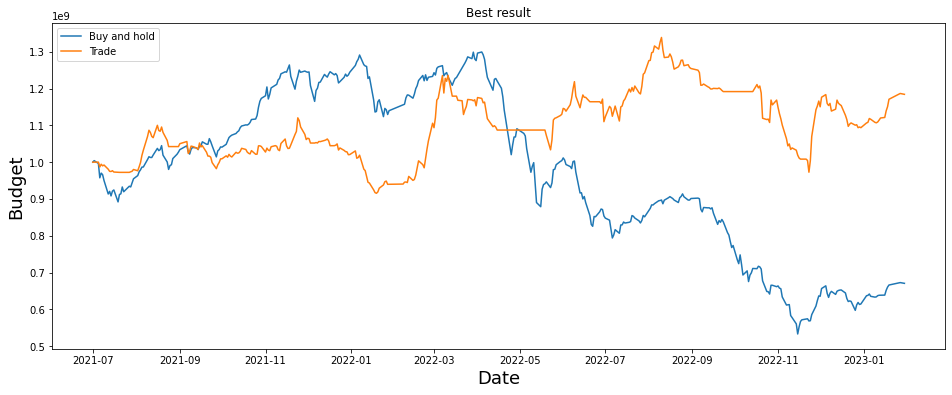

Day 2021-07-01
206 / 206 ticker growths
Portfolio
Portfolio cash: 1000000000, net value: 1000000000
Day 2021-07-02
206 / 206 ticker growths
Portfolio
Portfolio cash: 1000000000, net value: 1000000000
Day 2021-07-05
206 / 206 ticker growths
Portfolio
Portfolio cash: 1000000000, net value: 1000000000
Day 2021-07-06
Buy 2100 HOSE:TCM at price 91000.0 with pred 1.000
Buy 8500 HOSE:GEX at price 23600.0 with pred 1.000
206 / 206 ticker growths
Portfolio
HOSE:GEX : 8500.0, current price: 22700.0, current profit: -3.958%
HOSE:TCM : 2100.0, current price: 88700.0, current profit: -2.673%
Portfolio cash: 607712450.0, net value: 986932450.0
Day 2021-07-07
206 / 206 ticker growths
Portfolio
HOSE:GEX : 8500.0, current price: 23000.0, current profit: -2.688%
HOSE:TCM : 2100.0, current price: 91000.0, current profit: -0.150%
Portfolio cash: 607712450.0, net value: 994312450.0
Day 2021-07-08
206 / 206 ticker growths
Portfolio
HOSE:GEX : 8500.0, current price: 23000.0, current profit: -2.688%
HOSE:TCM 

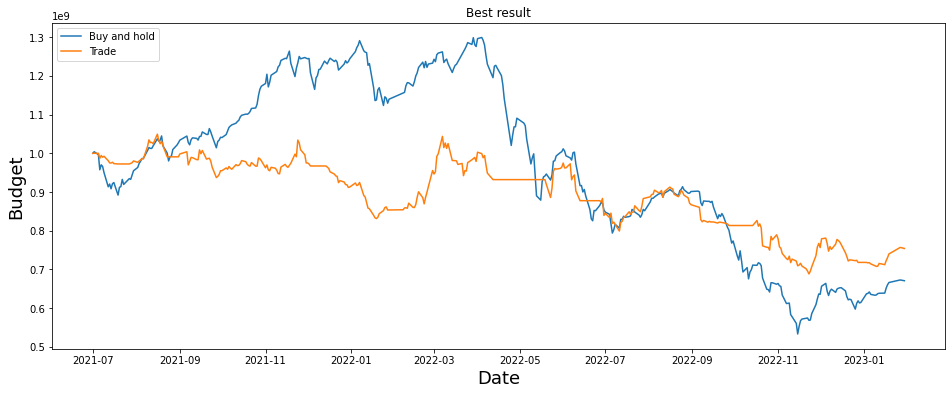

In [14]:
#Visualize the worst and the best scenario
best_index = np.argmax(backtest.final_sharp_ratios)
backtest.visualize(best_index)

print(backtest.logs[best_index])

worst_index = np.argmin(backtest.final_sharp_ratios)
backtest.visualize(worst_index)


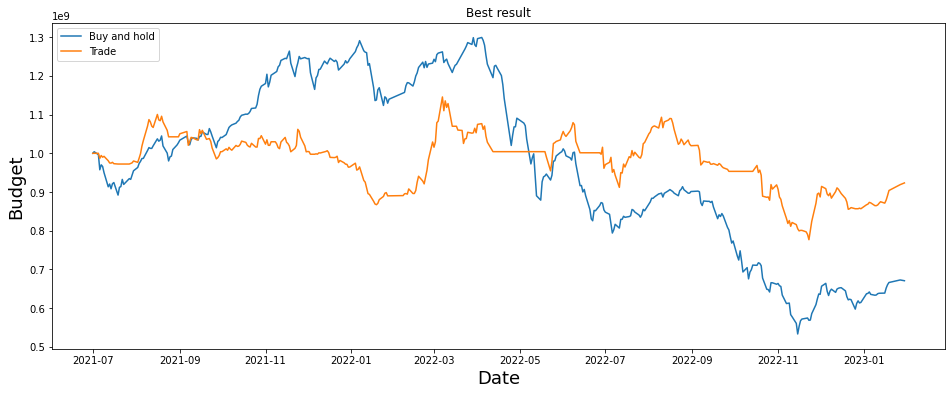

Day 2021-07-01
206 / 206 ticker growths
Portfolio
Portfolio cash: 1000000000, net value: 1000000000
Day 2021-07-02
206 / 206 ticker growths
Portfolio
Portfolio cash: 1000000000, net value: 1000000000
Day 2021-07-05
206 / 206 ticker growths
Portfolio
Portfolio cash: 1000000000, net value: 1000000000
Day 2021-07-06
Buy 2100 HOSE:TCM at price 91000.0 with pred 1.000
Buy 8500 HOSE:GEX at price 23600.0 with pred 1.000
206 / 206 ticker growths
Portfolio
HOSE:GEX : 8500.0, current price: 22700.0, current profit: -3.958%
HOSE:TCM : 2100.0, current price: 88700.0, current profit: -2.673%
Portfolio cash: 607712450.0, net value: 986932450.0
Day 2021-07-07
206 / 206 ticker growths
Portfolio
HOSE:GEX : 8500.0, current price: 23000.0, current profit: -2.688%
HOSE:TCM : 2100.0, current price: 91000.0, current profit: -0.150%
Portfolio cash: 607712450.0, net value: 994312450.0
Day 2021-07-08
206 / 206 ticker growths
Portfolio
HOSE:GEX : 8500.0, current price: 23000.0, current profit: -2.688%
HOSE:TCM 

In [15]:
#Visualize a random simulation

random_index = random.randint(0,99)
backtest.visualize(random_index)

print(backtest.logs[random_index])